## Importation des bibliothèques

In [3]:
import numpy as np
import PIL.Image as Image
import cv2
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras

## Chargement des données

In [3]:
data_dir = '.\\dataset'

In [4]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('dataset')

In [5]:
list(data_dir.glob('*/*.jpg'))[:5]

[WindowsPath('dataset/Air Jordan 1/air_jordan_1.jpg'),
 WindowsPath('dataset/Air Jordan 1/air_jordan_10.jpg'),
 WindowsPath('dataset/Air Jordan 1/air_jordan_11.jpg'),
 WindowsPath('dataset/Air Jordan 1/air_jordan_12.jpg'),
 WindowsPath('dataset/Air Jordan 1/air_jordan_13.jpg')]

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

200


In [9]:
modeles_chaussures_dict = {
    'air_jordan_1': list(data_dir.glob('Air Jordan 1/*')),
    'air_max_plus': list(data_dir.glob('Air Max Plus/*')),
    'mercurial': list(data_dir.glob('Mercurial/*')),
    'react': list(data_dir.glob('React/*')),
}

In [8]:
modeles_labels_dict = {
    'air_jordan_1': 0,
    'air_max_plus': 1,
    'mercurial': 2,
    'react': 3
}

In [10]:
modeles_chaussures_dict['air_jordan_1'][:5]

[WindowsPath('dataset/Air Jordan 1/air_jordan_1.jpg'),
 WindowsPath('dataset/Air Jordan 1/air_jordan_10.jpg'),
 WindowsPath('dataset/Air Jordan 1/air_jordan_11.jpg'),
 WindowsPath('dataset/Air Jordan 1/air_jordan_12.jpg'),
 WindowsPath('dataset/Air Jordan 1/air_jordan_13.jpg')]

In [11]:
str(modeles_chaussures_dict['air_jordan_1'][0])

'dataset\\Air Jordan 1\\air_jordan_1.jpg'

In [12]:
image = cv2.imread(str(modeles_chaussures_dict['air_jordan_1'][0]))

In [13]:
image.shape

(225, 225, 3)

In [14]:
cv2.resize(image,(224,224)).shape

(224, 224, 3)

## Création d'un dataset à partir des données chargées

In [15]:
X, y = [], []

for chaussure_name, images in modeles_chaussures_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(modeles_labels_dict[chaussure_name])

In [16]:
X = np.array(X)
y = np.array(y)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [18]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [19]:
X_train.shape

(150, 224, 224, 3)

## Transfer Learning : mobilenet_v2

In [5]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pretrained_model = hub.KerasLayer(
    feature_extractor_model, 
    input_shape=(224, 224, 3), 
    trainable=False
)

In [6]:
model = tf_keras.Sequential([
    pretrained_model,
    tf_keras.layers.Dense(4, activation='softmax')
])

In [30]:
model.compile(
    optimizer=tf_keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_4 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2263108 (8.63 MB)
Trainable params: 5124 (20.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [32]:
model.fit(X_train_scaled, y_train, epochs=15)

Epoch 1/15
5/5 [==============================] - 9s 691ms/step - loss: 1.2122 - accuracy: 0.4333
Epoch 2/15
5/5 [==============================] - 3s 662ms/step - loss: 0.8652 - accuracy: 0.7200
Epoch 3/15
5/5 [==============================] - 3s 645ms/step - loss: 0.6492 - accuracy: 0.8733
Epoch 4/15
5/5 [==============================] - 3s 656ms/step - loss: 0.4802 - accuracy: 0.9400
Epoch 5/15
5/5 [==============================] - 3s 694ms/step - loss: 0.3741 - accuracy: 0.9600
Epoch 6/15
5/5 [==============================] - 3s 659ms/step - loss: 0.2984 - accuracy: 0.9667
Epoch 7/15
5/5 [==============================] - 3s 647ms/step - loss: 0.2435 - accuracy: 0.9800
Epoch 8/15
5/5 [==============================] - 3s 661ms/step - loss: 0.2064 - accuracy: 0.9933
Epoch 9/15
5/5 [==============================] - 3s 648ms/step - loss: 0.1761 - accuracy: 1.0000
Epoch 10/15
5/5 [==============================] - 3s 647ms/step - loss: 0.1525 - accuracy: 1.0000
Epoch 11/15
5/5 [==

### 100% Accuracy sur les données d'entraînement

In [33]:
model.evaluate(X_test_scaled, y_test)

2/2 [==============================] - 4s 537ms/step - loss: 0.2040 - accuracy: 0.9400


[0.20396925508975983, 0.9399999976158142]

### 94% Accuracy sur les données de test

In [34]:
labels = ['Air Jordan 1', 'Air Max Plus', 'Mercurial', 'React']

## Affichage de quelques images de test avec leurs labels

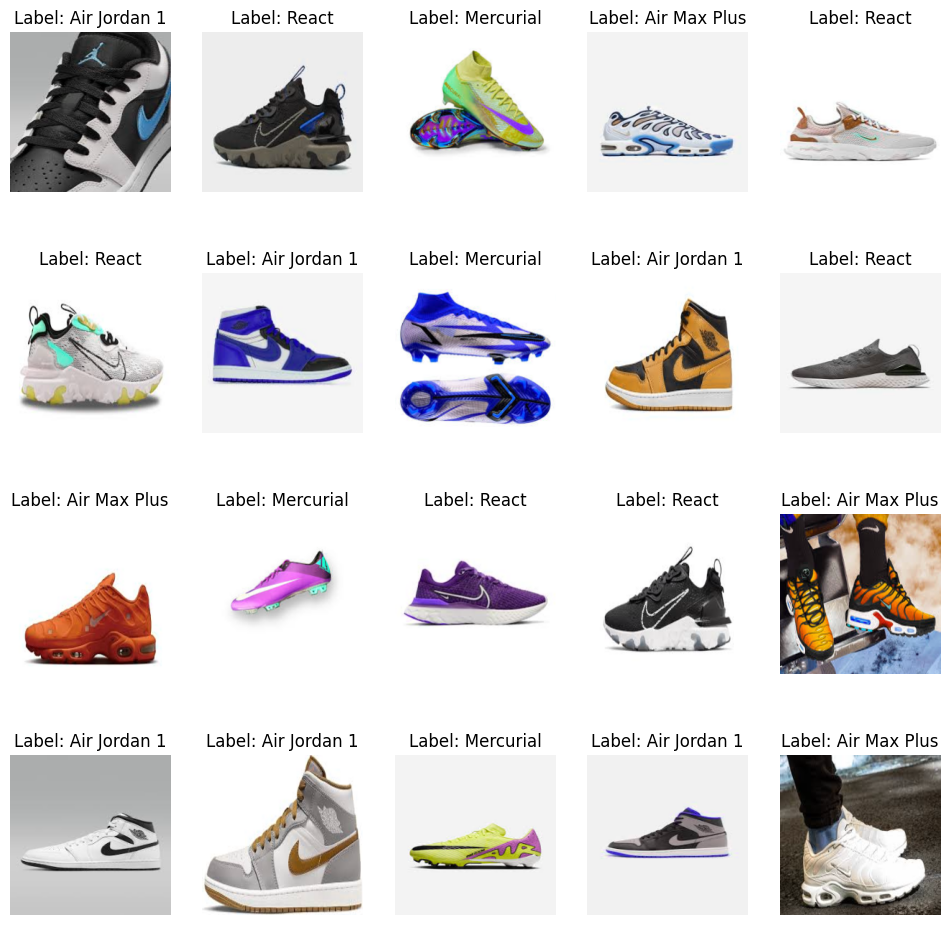

In [35]:
plt.figure(figsize=(12, 12))
for i in range(20):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(X_test[i].astype("uint8"))
    plt.title(f"Label: {labels[y_test[i]]}")
    plt.axis("off")
plt.show()

## Prédiction des images de test avec notre modèle

In [36]:
y_pred = model.predict(X_test_scaled)

2/2 [==============================] - 3s 435ms/step


In [37]:
y_pred = [np.argmax(i) for i in y_pred]

## Affichage de quelques images de test avec leurs prédiction

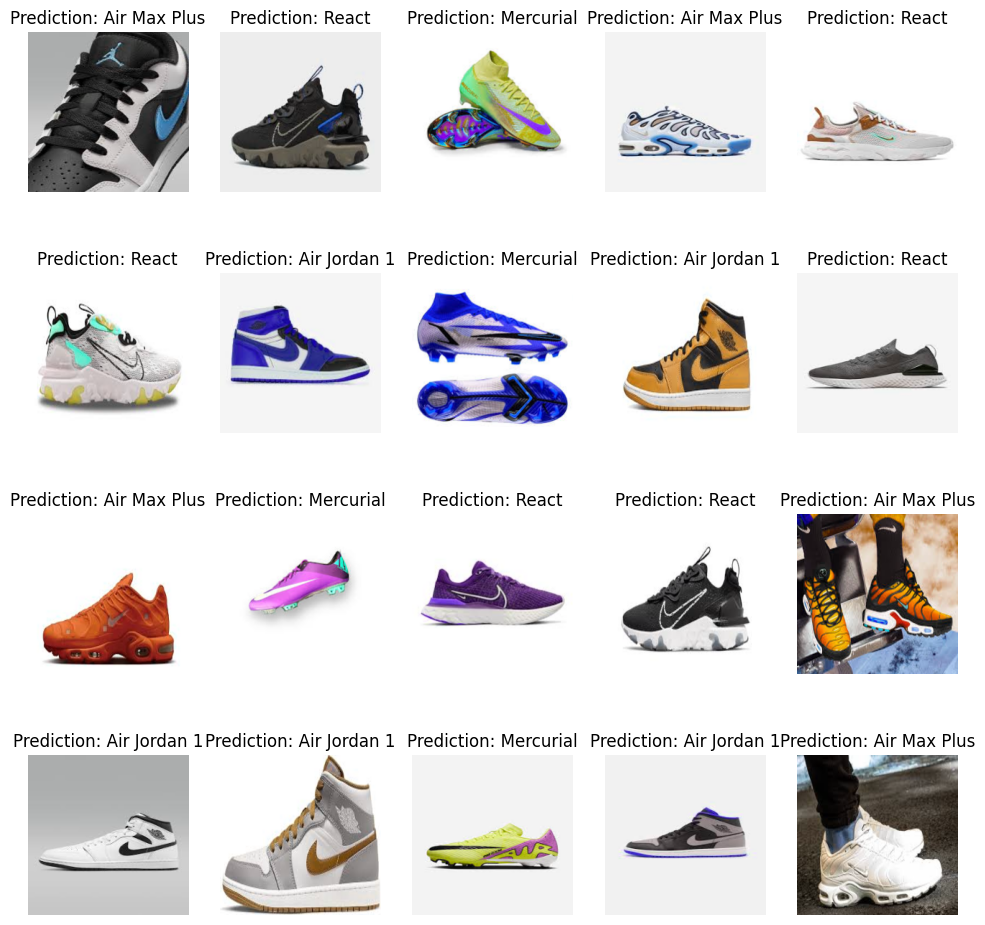

In [38]:
plt.figure(figsize=(12, 12))
for i in range(20):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(X_test[i].astype("uint8"))
    plt.title(f"Prediction: {labels[y_pred[i]]}")
    plt.axis("off")
plt.show()

## Rapport de Classification

In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.90      0.90      0.90        10
           2       1.00      1.00      1.00        14
           3       0.87      1.00      0.93        13

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.95      0.94      0.94        50



# Test sur des images de chaussures récupérées depuis Google

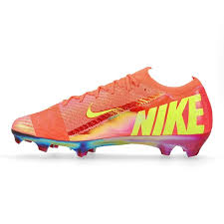

In [40]:
chaussure = Image.open('mercurial.jpg').resize((224, 224))
chaussure = chaussure.convert("RGB")
chaussure

In [41]:
chaussure = np.array(chaussure) / 255
chaussure.shape

(224, 224, 3)

In [42]:
predict_chaussure = model.predict(chaussure[np.newaxis, ...])
predict_chaussure.shape

1/1 [==============================] - 1s 827ms/step


(1, 4)

In [43]:
predicted_chaussure = np.argmax(predict_chaussure)
labels[predicted_chaussure]

'Mercurial'

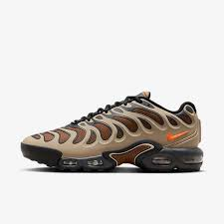

In [44]:
chaussure = Image.open('airmaxplus.jpg').resize((224, 224))
chaussure = chaussure.convert("RGB")
chaussure

In [45]:
chaussure = np.array(chaussure) / 255
chaussure.shape

(224, 224, 3)

In [46]:
predict_chaussure = model.predict(chaussure[np.newaxis, ...])
predict_chaussure.shape

1/1 [==============================] - 1s 794ms/step


(1, 4)

In [47]:
predicted_chaussure = np.argmax(predict_chaussure)
labels[predicted_chaussure]

'Air Max Plus'